<a href="https://colab.research.google.com/github/wangpengcn/Credit-Card-Fraud-Detection/blob/master/credit_card_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import sys, os
from time import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, average_precision_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Google Drive Access Setup

In [8]:
# Only need to run this cell when using Google Colab
# Install a Drive FUSE wrapper.
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate


··········


In [0]:
# Only need to run this cell when using Google Colab
# mount Google drive
from google.colab import drive
if (os.path.isdir('/content/gdrive')==False):
  drive.mount('/content/gdrive')
basepath = '/content/gdrive/My Drive/Colab Notebooks/credit_card_fraud'
sys.path.insert(0, basepath)
os.chdir(basepath)

# **Data Preps**

In [0]:
# Read the CSV file
data = pd.read_csv('./data/creditcard.csv')

In [33]:
# Show top 5 rows
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [34]:
# Check if any null value
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [0]:
# Normalize Amount column (It seems the other columns are normalized)
data['scaledAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
# Drop Time and Amount column
data = data.drop(['Time','Amount'],axis=1)

% of frauds: 0.17 % of the dataset


Text(0, 0.5, 'Frequency')

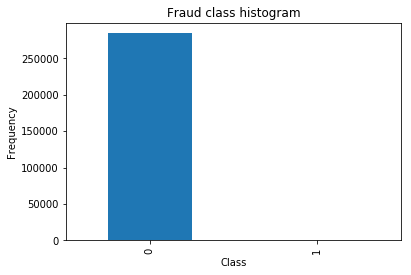

In [37]:
# Classes are heavily skewed 
num_fraud = data['Class'].value_counts()[1]
print('% of frauds:', round(num_fraud/len(data) * 100,2), '% of the dataset')
# Plot number of fraud and legit records
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

# Train Model

In [0]:
def train_model(X_train, y_train):
    # Split training for 5-fold validation
    sss = StratifiedShuffleSplit(n_splits=5, random_state=20)
    # Logistic Regression
    model = LogisticRegression(solver='liblinear')
    # Random grid search on hyperparameters
    params = {"penalty": ['l1', 'l2'], 'C': [0.1, 1, 10, 100]}
    '''
    To optimize precision-recall score (average precision score)
    AP summarizes a precision-recall curve as the weighted mean of precisions 
    achieved at each threshold, with the increase in recall from the previous 
    threshold used as the weight
    '''
    scoring = {'ave_prec': 'average_precision'}
    n_iter = 6
    grid_search = RandomizedSearchCV(model, 
                                  params, 
                                  scoring=scoring,
                                  random_state= 50,
                                  refit='ave_prec', 
                                  cv=sss,
                                  n_iter=n_iter,
                                  verbose=1,
                                  n_jobs=-1)
    
    start = time() # start time
    lr_fit = grid_search.fit(X_train, y_train)
    lr_best = grid_search.best_estimator_
    end = time() # end time
    # Calculate training time
    search_time = (end-start)/60.
    print('--'*30)
    print('Took {0:.2f} minutes to find optimal parameters'.format(search_time))
    print('Best parameters for model: {}'.format(lr_fit.best_params_))
    print('Best precision-recall socre from training: {}'.format(lr_fit.best_score_))
    return lr_best  

In [0]:
def predict_test(model, X_test, y_test):
    y_test_pred = model.predict(X_test)
    print("Confusion Matrix")
    print(confusion_matrix(y_test, y_test_pred))
    print("Classification Report")
    print(classification_report(y_test, y_test_pred))
    print('--'*30)
    # Plot precision-recall curve
    # Compute precision-recall pairs for different probability threshold
    precision, recall, _ = precision_recall_curve(y_test, model.decision_function(X_test))
    plt.figure(figsize=(12,6))
    plt.plot(recall, precision, c='b' )
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    pr_score = average_precision_score(y_test, model.decision_function(X_test))
    plt.title('Test PR curve: \n Average Precision-Recall Score ={0:0.2f}'.format(pr_score, fontsize=14))
    plt.grid(b=True, which='major', c='g', linestyle='-', alpha=0.2)
    plt.show()

In [0]:
# Separate labels from features
X = data.loc[:,data.columns!='Class']
y = data['Class']
# Split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)

## Train and test using original imbalanced dataset

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.7min finished


------------------------------------------------------------
Took 2.83 minutes to find optimal parameters
Best parameters for model: {'penalty': 'l2', 'C': 0.1}
Best precision-recall socre from training: 0.7642589240077233
Confusion Matrix
[[56855     9]
 [   44    54]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.55      0.67        98

    accuracy                           1.00     56962
   macro avg       0.93      0.78      0.84     56962
weighted avg       1.00      1.00      1.00     56962

------------------------------------------------------------


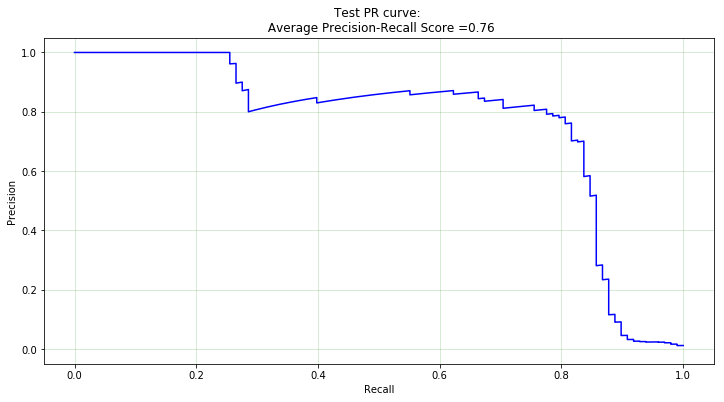

In [23]:
# -----------  Train and test imbalanced datasets ----------
model_regular = train_model(X_train, y_train)
predict_test (model_regular, X_test, y_test)

## Train and test using SMOTE oversampled dataset

In [0]:
# -----------  SMOTE (Synthetic Minority Over-sampling Technique) ----------
X_train_smote, y_train_smote = SMOTE(sampling_strategy='minority').fit_resample(X_train, y_train)
model_smote = train_model(X_train_smote, y_train_smote)
predict_test (model_smote, X_test, y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
